In [1]:
%config InlineBackend.figure_format = 'svg'

# === IMPORTS ===

from typing import cast, Literal
import random

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.colors
import matplotlib.cm
import kmedoids
from scipy.optimize import minimize
from scipy.stats import linregress
from sklearn.manifold import MDS

from pdfa import PDFA
import machines
import ffutils as ff
from ffutils import Model, TestConfig, TrainRun, TestRun, ModelType, EnsMode, VoteStrat
import variety as var
from variety import PruningMethod
from export import import_pdfa_json
from clock import SimpleClock
from cache import Cache


# === GLOBAL OBJECTS ===

CORES = 12
CLOCK = SimpleClock()
CACHE = Cache()

RANDOM_3_CACHE_KEY = 501
RANDOM_4_CACHE_KEY = 503

STANDARD_TEST = ff.create_standard_config("test")
REBER_CONFIG = ff.create_standard_config("reber")
PARITY_CONFIG = ff.create_standard_config("parity")
PAUTOMAC_TEST = TestConfig(
    name = "PAutomaC",
    dir = "PAutomaC-competition_sets",
    train_suffix = ".pautomac.train.dat",
    model_suffix = ".pautomac.train.dat.ff",
    solution_suffix = ".pautomac_solution.txt",
    test_suffix = ".pautomac.test.dat"
)

def RANDOM_CONFIG(id: int) -> TestConfig:
    return ff.create_standard_config(f"random_{id}", dir="random")

def RANDOM_MACHINE(id: int) -> PDFA:
    return import_pdfa_json(input_file=f"./../models/random_{id}.json")

In [2]:
def plot_perplexity_vs_imv(scores: list[float], imvs: list[float], colors: list[float]|None = None, colrange: tuple[float, float] = (0.0, 7.0), title: str = "Ensemble Performance vs Diversity"):
    """
    Plots a scatterplot of perplexity (performance) vs inter-model variety (diversity).
    
    Parameters:
    - scores: List of ensemble perplexity values (lower is better).
    - imvs: List of inter-model variety (IMV) values (diversity metric).
    - title: Title of the plot.
    """
    if len(scores) != len(imvs):
        raise ValueError("Length of scores and imvs must be equal")

    Y = np.array(scores)
    X = np.array(imvs)

    plt.figure(figsize=(10, 8))
    if colors is None:
        plt.scatter(X, Y, s=50)
    else:    
        # min_color, max_color = min(colors), max(colors)
        C = np.array(colors)
        scatter = plt.scatter(X, Y, c=C, s=50, cmap="cool")
        cbar = plt.colorbar(scatter)
        cbar.set_label("Training Randomness", rotation=270, labelpad=15)

    # plt.axhline(y=Y[0], color='cyan', linewidth=1) # Baseline score for deterministic model
    plt.xlabel("Inter-Model Variety (IMV)")
    plt.ylabel("Perplexity (lower is better)")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


def plot_perplexity_vs_imv_with_means(
        scores: list[float], 
        imvs: list[float], 
        colors: list[float], 
        colrange: tuple[float, float] = (0.0, 7.0), 
        title: str = "Mean Ensemble Performance vs Diversity"
    ):
    """
    Plots a separate scatterplot of mean IMV vs perplexity per group, with error bars (std dev).
    Assumes 'colors' identifies group membership (e.g., training randomness).
    """
    if not (len(scores) == len(imvs) == len(colors)):
        raise ValueError("scores, imvs, and colors must be the same length")

    # Data for the left subplot
    Y = np.array(scores)
    X = np.array(imvs)
    C = np.array(colors)

    # Group values by color
    grouped_x: dict[float, list[float]] = {c: [] for c in C}
    grouped_y: dict[float, list[float]] = {c: [] for c in C}

    for x, y, c in zip(X, Y, C):
        grouped_x[c].append(x)
        grouped_y[c].append(y)
    
    # Data for the right subplot
    C_keys = np.array(list(grouped_x.keys()))
    X_avg = [np.mean(xs) for xs in grouped_x.values()]
    X_std = [np.std(xs) for xs in grouped_x.values()]
    Y_avg = [np.mean(ys) for ys in grouped_y.values()]
    Y_std = [np.std(ys) for ys in grouped_y.values()]

    # Normalize color values
    norm = matplotlib.colors.Normalize(vmin=np.min(C_keys), vmax=np.max(C_keys))
    mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap="cool")

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

    # Left subplot: all data points
    scatter = ax1.scatter(X, Y, c=C, s=50, cmap="cool")
    ax1.set_title("All Models")
    ax1.set_xlabel("Inter-Model Variety (IMV)")
    ax1.set_ylabel("Perplexity (lower is better)")
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Right subplot: group means with error bars
    ax2.scatter(X_avg, Y_avg, c=C_keys, cmap="cool")
    ax2.set_title("Group Averages with Error Bars")
    ax2.set_xlabel("Inter-Model Variety (IMV)")
    ax2.grid(True, linestyle='--', alpha=0.6)

    # Plot right subplot error bars
    for i, c in enumerate(C_keys):
        color = mapper.to_rgba(c)
        plt.errorbar(X_avg[i], Y_avg[i], xerr=X_std[i], yerr=Y_std[i], fmt='none', color=color, elinewidth=2, capsize=5)

    # Shared colorbar
    cbar = fig.colorbar(scatter, location="right", ax=[ax1, ax2])
    cbar.set_label("Training Randomness", rotation=270, labelpad=15)

    plt.suptitle(title, fontsize=14)
    # plt.tight_layout(rect=(0.0, 0.0, 0.97, 0.95))  # Leave space for colorbar and title
    plt.show()


def eval_diversity_vs_performance(
    machine = import_pdfa_json(input_file="./../models/random_1.json"),
    config = ff.create_standard_config("random_1", dir="random"),
    trainset_size = 300,
    testset_size = 1000,
    sample_size = 300,
    num_models = 24,
    num_runs_per_model = 5,
    min_rand = 0.5,
    max_rand = 7.0,
    nrestimators = 15,
    plot_means = False,
    skip_generate = False,
    skip_train = False
):
    
    CLOCK.start()

    # Extract the configuration from params
    trainset = f"{config.name}_{trainset_size}"
    testset = f"{config.name}_{testset_size}"

    if not skip_generate:
        # Create train and test set
        print(f"Generating train and testsets: {trainset}, {testset}")
        ff.write_trainset(config, machine, trainset, trainset_size)
        ff.write_testset(config, machine, testset, testset_size)
    else:
        print(f"Skipped generating train and testsets: {trainset}, {testset}")

    # GREEDY models with varying randomness
    zero_model = Model.Greedy(f"IMV_GREEDY_0", nrestimators=1, rand=0)
    models = [
        Model.Greedy(f"IMV_GREEDY_{rand}", nrestimators=nrestimators, rand=rand)
        for rand in np.linspace(min_rand, max_rand, num_models)
    ]

    # Several random runs for each configuration and one run for the deterministic model
    runs: list[TrainRun] = []
    runs.append(zero_model.into_run(trainset_name=trainset, run_name="0"))
    for run_num in range(num_runs_per_model):
        for model in models:
            run = model.into_run(trainset_name=trainset, run_name=f"{run_num}")
            runs.append(run)

    # Train and test each model on the same trainset and testset
    if not skip_train:
        ff.train_models_batch(config, runs, CORES)
        print(f"Finished training {len(runs)} runs on {trainset}: {CLOCK.measure()}")
    else:
        print(f"Skipped training {len(runs)} runs on {trainset}")
    test_runs = TestRun.from_train_runs(runs, testset)
    scores = ff.test_models_batch(config, test_runs)
    print(f"Finished testing {len(runs)} runs on {testset}: {CLOCK.measure()}")
    
    # Now compute IMVs
    imvs = []
    diffs = ff.diff_models_batch(config, runs, sample_size=sample_size)
    for flat_array, run in zip(diffs, runs):
        # H = var.scores_flat_to_normalized_cross_entropy(flat_array, run.model.nrestimators)
        D = var.scores_flat_to_distance_matrix_gao(flat_array, run.model.nrestimators)
        imv = var.compute_imv(D, run.model.nrestimators)
        imvs.append(imv)
    print(f"Finished diffing {len(runs)}, smaple_size={sample_size}: {CLOCK.measure()}")
    print(f"Total time: {CLOCK.stop()}")

    # Colors
    colors = [run.model.random_factor for run in runs]

    # Plot the scores
    if plot_means:
        plot_perplexity_vs_imv_with_means(scores, imvs, colors=colors, colrange=(0.0, max_rand), title=f"Ensemble Performance vs Diversity ({config.name})")
    else:
        plot_perplexity_vs_imv(scores, imvs, colors=colors, colrange=(0.0, max_rand), title=f"Ensemble Performance vs Diversity ({config.name})")



def scatter_perplexity_vs_imv(scores: list[float], imvs: list[float], title: str):
    """
    Plots a scatterplot of perplexity (performance) vs weighted imv (diversity). Includes performance with uniform
    weights as a baseline.
    """
    if len(scores) != len(imvs):
        raise ValueError("Length of scores and imvs must be equal")

    Y = np.array(scores)
    X = np.array(imvs)

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(X, Y)
    line = slope * X + intercept

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(X, Y, s=50, alpha=0.6, color = "blue", label="Randomly Pruned Ensemble")
    plt.plot(X, line, color='red', linestyle='--', label=f"Linear Fit (r={r_value:.2f}, p={p_value:.3g})")

    # plt.axhline(y=Y[0], color='cyan', linewidth=1) # Baseline score for deterministic model
    plt.xlabel("Inter-Model Variety (IMV)")
    plt.ylabel("Perplexity (lower is better)")
    plt.title(title)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Linear regression results:")
    print(f"  Slope: {slope:.4f}")
    print(f"  Intercept: {intercept:.4f}")
    print(f"  Pearson r: {r_value:.4f}")
    print(f"  p-value: {p_value:.4g}")
    print(f"  Std error: {std_err:.4f}")


def eval_random_imv_vs_performance(
    machine: PDFA|None,
    config: TestConfig,
    m = 400,
    n = 20,
    rand = 2.5,
    trainset_size = 300,
    testset_size = 1000,
    num_test_runs = 100, # Number of plotted points
    sample_size = 300,
    skip_train = False,
    skip_diff = False,
    cache_key: int = 41414
):
    
    CLOCK.start()

    # Extract the configuration from params
    trainset = f"{config.name}_{trainset_size}"
    testset = f"{config.name}_{testset_size}"
    model = Model.Greedy(f"PRUNED", nrestimators=m, rand=rand)

    if machine:
        ff.write_testset(config, machine, testset, testset_size)
    if not skip_train and machine:
        # Create train and test set
        print(f"Generating train and testsets: {trainset}, {testset}")
        ff.write_trainset(config, machine, trainset, trainset_size)

    # Train the runs
    train_runs = model.split_into_parallel_runs(trainset_name=trainset)
    if not skip_train:
        ff.train_models_batch(config, train_runs, number_of_cores=10)
        print(f"Finished training {len(train_runs)} models on {trainset}: {CLOCK.measure()}")

    # Now get all diffs
    if skip_diff:
        diffs_flat = CACHE.load(cache_key, from_disk=True)[-1]
    else:
        diffs_flat = ff.diff_model(config, model.into_run(trainset_name=trainset), sample_size)
        print(f"Finished diffing the {len(train_runs)} models, smaple_size={sample_size}: {CLOCK.measure()}")

    H = var.scores_flat_to_normalized_cross_entropy(diffs_flat, m)

    # Now create all the test runs with random selections (they are all the same config)
    imvs = []
    test_runs = []
    all_models: list[int] = list(range(m))

    for i in range(num_test_runs):
        selection = random.sample(all_models, n)
        H_small = H[np.ix_(selection, selection)]
        imvs.append(var.compute_imv(H_small, n))
        test_runs.append(model.into_test(testset_name=testset, ens_models=selection))

    scores = ff.test_models_batch(config, test_runs)
    print(f"Finished testing {num_test_runs} runs on {testset}: {CLOCK.measure()}")

    print(f"Total time: {CLOCK.stop()}")

    # Plot the scores
    scatter_perplexity_vs_imv(scores, imvs, title=f"Randomly Pruned Ensemble Performance vs IMV on {config.name}; m={m}, n={n}")



Generating train and testsets: reber_30, reber_400
Finished training 101 runs on reber_30: 0m 4s
Finished testing 101 runs on reber_400: 0m 17s
Finished diffing 101, smaple_size=300: 0m 8s
Total time: 0m 30s


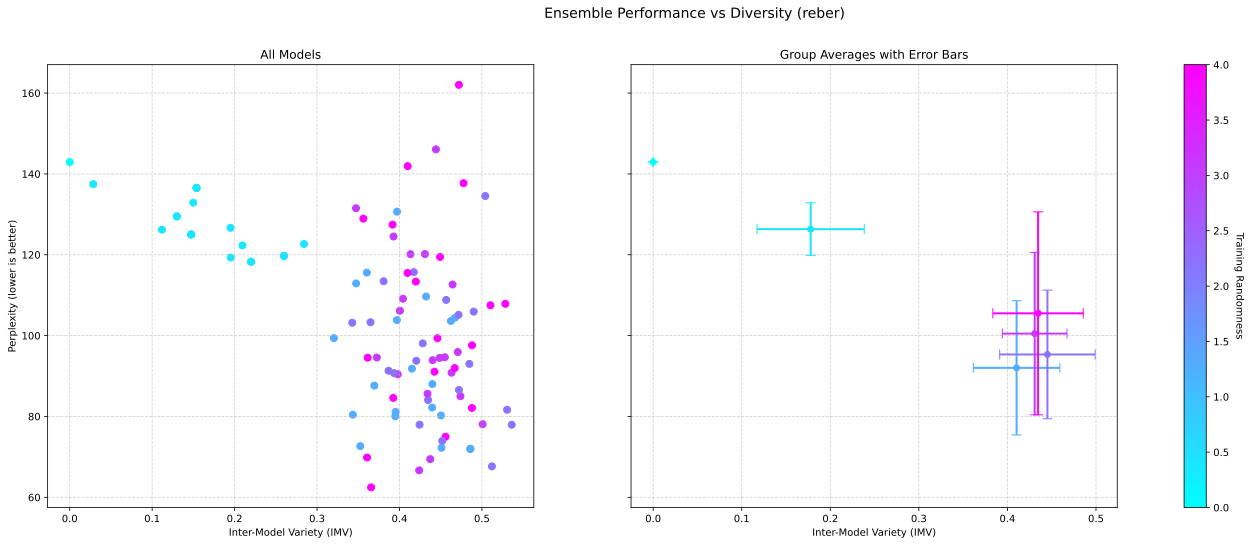

In [3]:
eval_diversity_vs_performance(
    machine=machines.reber(), 
    config=REBER_CONFIG, 
    trainset_size=30, 
    testset_size=400,
    num_models=5,
    num_runs_per_model=20,
    min_rand=0.4,
    max_rand=4,
    skip_generate=False,
    skip_train=False,
    plot_means=True
)

Skipped generating train and testsets: random_3_250, random_3_1000
Skipped training 301 runs on random_3_250
Finished testing 301 runs on random_3_1000: 1m 27s
Finished diffing 301, smaple_size=500: 0m 50s
Total time: 2m 17s


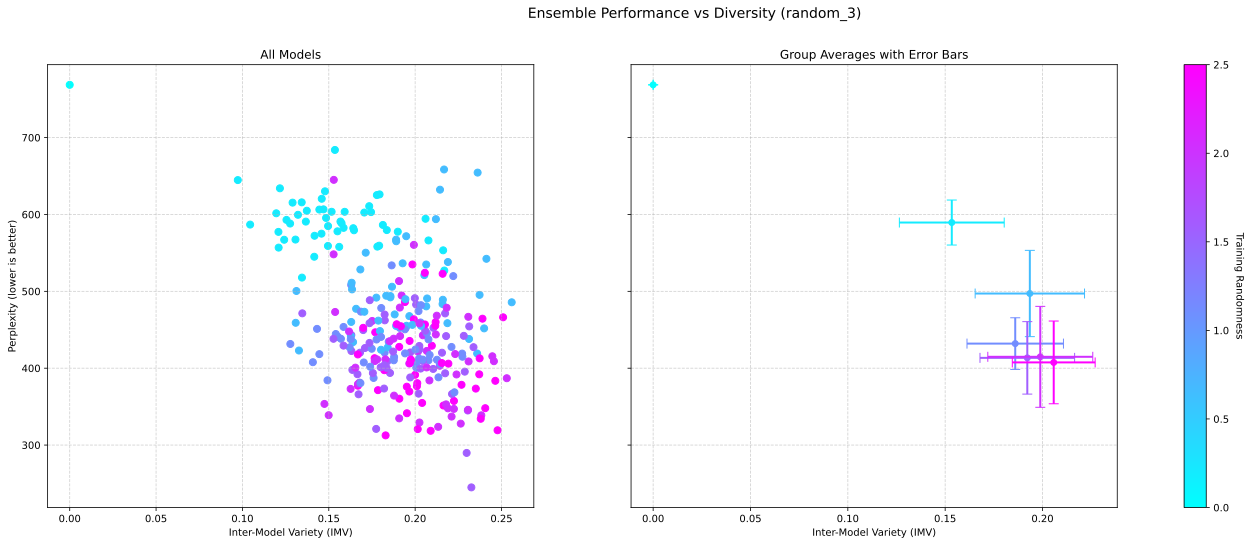

In [4]:
eval_diversity_vs_performance(
    machine=RANDOM_MACHINE(3), 
    config=RANDOM_CONFIG(3), 
    trainset_size=250, 
    testset_size=1000,
    num_models=6,
    sample_size=500,
    num_runs_per_model=50,
    min_rand=0.2,
    max_rand=2.5,
    skip_generate=True,
    skip_train=True,
    plot_means=True
)

Generating train and testsets: reber_35, reber_200
Finished training 200 models on reber_35: 0m 2s
Finished diffing the 200 models, smaple_size=300: 1m 24s
Finished testing 300 runs on reber_200: 0m 35s
Total time: 2m 2s


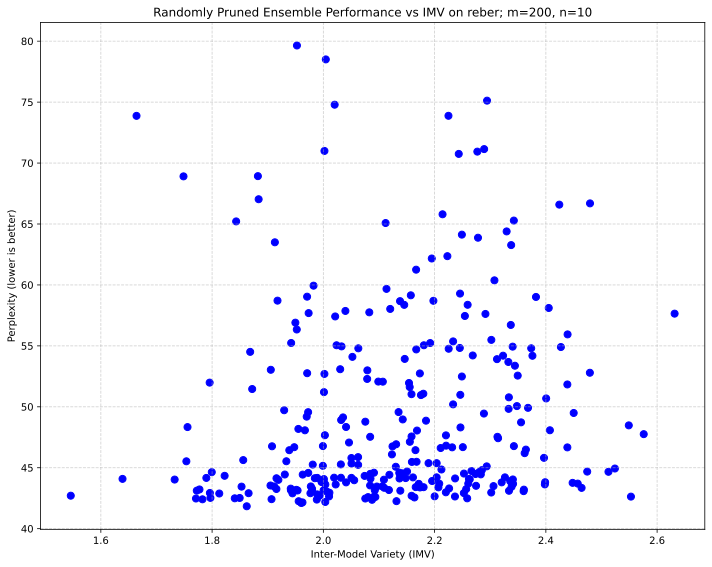

In [12]:
eval_random_imv_vs_performance(
    machine = machines.reber(),
    config = REBER_CONFIG,
    num_test_runs=300,
    trainset_size=35,
    testset_size=200,
    sample_size=300,
    m = 200,
    n = 10
)

Finished testing 500 runs on random_3_1000: 3m 13s
Total time: 3m 13s


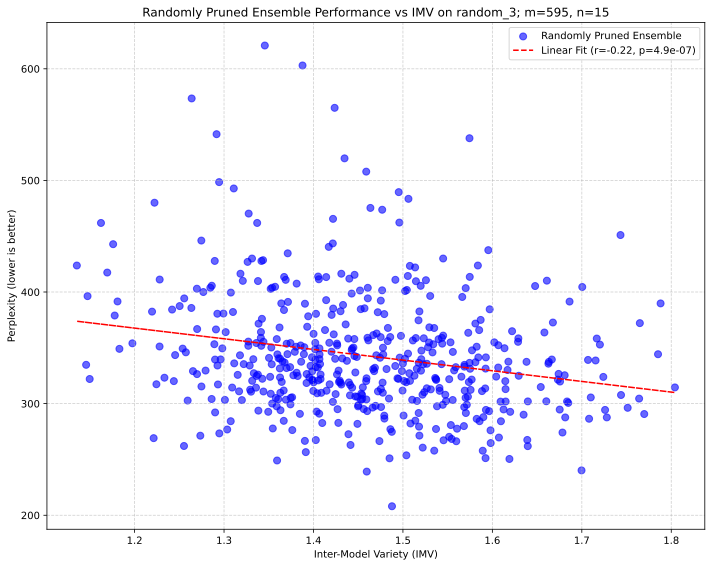

Linear regression results:
  Slope: -95.5229
  Intercept: 482.2843
  Pearson r: -0.2227
  p-value: 4.904e-07
  Std error: 18.7402


In [30]:
eval_random_imv_vs_performance(
    machine=None,
    config = RANDOM_CONFIG(3),
    num_test_runs=500,
    trainset_size=200,
    sample_size=700,
    testset_size=1000,
    m = 595,
    n = 15,
    cache_key=RANDOM_3_CACHE_KEY,
    skip_diff=True,
    skip_train=True
)

[Cache] Loaded key 503 from .cache\503.pkl
Finished testing 500 runs on random_4_1000: 12m 54s
Total time: 12m 54s


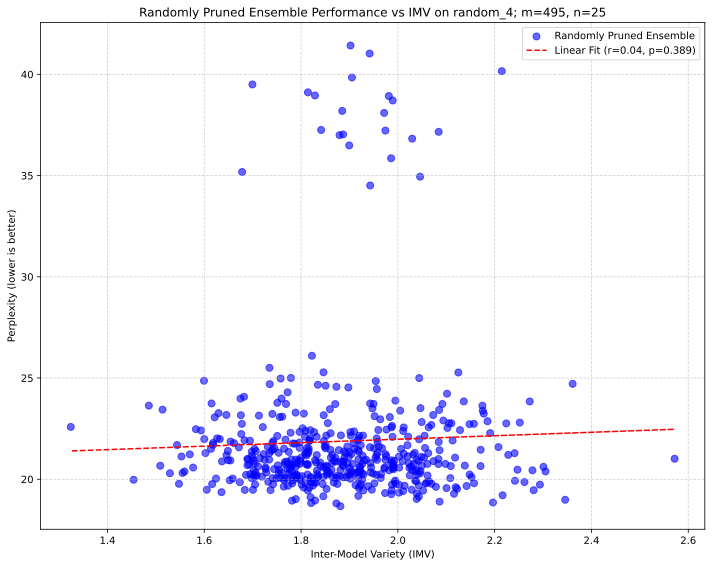

Linear regression results:
  Slope: 0.8573
  Intercept: 20.2633
  Pearson r: 0.0386
  p-value: 0.3888
  Std error: 0.9940


In [32]:
eval_random_imv_vs_performance(
    machine=RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    num_test_runs=500,
    trainset_size=150,
    sample_size=1000,
    testset_size=1000,
    m = 495,
    n = 25,
    cache_key=RANDOM_4_CACHE_KEY,
    skip_diff=True,
    skip_train=True
)

In [3]:
def reduce_xticks(xticks: list[int]|list[float], max_ticks: int = 20) -> list:
    n = len(xticks)
    if n <= max_ticks:
        return list(xticks)

    step = max(1, n // max_ticks)
    indices = list(range(0, n, step))
    # Ensure the last tick is included
    if indices[-1] != n - 1:
        indices[-1] = n - 1
    return [xticks[i] for i in indices]


def plot_regular_vs_pruned(eq_scores, pru_scores, ens_sizes: list[int], pruned_size: int, title: str = ""):

    # Plot the results
    plt.figure(figsize=(8, 5))

    plt.plot(ens_sizes, eq_scores, label="ALL", color="blue")
    plt.plot(ens_sizes, pru_scores, label=f"PRUNED(size={pruned_size})", color="orange")

    plt.title(title)
    plt.xlabel("Number of generated models")
    plt.ylabel("Perplexity")
    plt.xticks(reduce_xticks(ens_sizes, max_ticks=10))
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


def eval_pruned_vs_performance(
    machine: PDFA,
    config: TestConfig,
    trainset_size = 300,
    testset_size = 1000,
    ens_sizes = [i for i in range(10, 201, 10)], # Number of plotted points
    rand = 4.0,
    n = 10,
    sample_size = 300,
    pruning_method: PruningMethod = PruningMethod.MaxImv(),
    skip_train = False,
    cache_key = 113,
    skip_diff = False,
    continue_work = False
):
    
    CLOCK.start()

    # Extract the configuration from params
    trainset = f"{config.name}_{trainset_size}"
    testset = f"{config.name}_{testset_size}"

    if skip_train or continue_work:
        print(f"Skipped generating train and testsets: {trainset}, {testset}")
    else:
        # Create train and test set
        print(f"Generating train and testsets: {trainset}, {testset}")
        ff.write_trainset(config, machine, trainset, trainset_size)
        ff.write_testset(config, machine, testset, testset_size)

    # Configure models and runs
    # Single model with the maximum number of ensemble models
    total_estimators = ens_sizes[-1]
    model = Model.Greedy(f"PRUNED", nrestimators=total_estimators, rand=rand)

    # Train the models
    if skip_train:
        print(f"Skipped training {total_estimators} runs on {trainset}")
    else:
        train_runs = model.split_into_parallel_runs(trainset_name=trainset, continue_work=continue_work)
        ff.train_models_batch(config, train_runs)
        print(f"Finished training {len(train_runs)} runs on {trainset}: {CLOCK.measure()}")

    if skip_diff:
        matrices_flat = CACHE.load(cache_key, from_disk=True)
        print(f"Skipped diffing")
    else:
        # Collect the cross entropy matrices
        diff_runs = [model.into_run(trainset_name=trainset, nrestimators=m) for m in ens_sizes]
        matrices_flat = ff.diff_models_batch(config, diff_runs, sample_size)
        CACHE.save(matrices_flat, cache_key, to_disk=True)
        print(f"Finished diffing {len(diff_runs)} models: {CLOCK.measure()}")

    # Perform all the weights, imv calculation and testing
    ens_models = []
    for flat_matrix, m in zip(matrices_flat, ens_sizes):
        # selected_idxs = optimize_model_selection(H, m, n, budget=500)
        if n < m:
            selected_idxs = pruning_method.prune(flat_matrix, m, n)
        else:
            selected_idxs = [i for i in range(m)]
        ens_models.append(selected_idxs)
    print(f"Finished prunning {len(ens_sizes)} models: {CLOCK.measure()}")

    # Test each model with 2 configs: equal and optimal weights
    equal_test_runs = [model.into_test(testset_name=testset, vote_strat=VoteStrat.UNIFORM, nrestimators=m) for m in ens_sizes]
    pruned_test_runs = [model.into_test(testset_name=testset, vote_strat=VoteStrat.UNIFORM, ens_models=selection) for selection in ens_models]
    all_test_runs = equal_test_runs + pruned_test_runs
    all_scores = ff.test_models_batch(config, all_test_runs)
    assert len(all_scores) == 2 * len(ens_sizes)
    eq_scores = all_scores[:len(equal_test_runs)]
    pru_scores = all_scores[len(equal_test_runs):]
    print(f"Finished testing {len(all_test_runs)} runs: {CLOCK.measure()}")

    for m, selection in zip(ens_sizes, ens_models):
        print(f"Selected from {m}: {selection}")

    print(f"Total time: {CLOCK.stop()}")


    # Plot the scores
    plot_regular_vs_pruned(eq_scores, pru_scores, ens_sizes, pruned_size=n, title=f"All models vs pruned with {pruning_method.name} on ({config.name})")



def plot_pruned_by_distance(
        series: list[tuple[str, list[int]]],
        distance_matrix: np.ndarray,
        print_distances=False,
        title = None,
    ):
    if not title:
        title = "MDS: Pruned vs All"
    if print_distances:
        np.set_printoptions(threshold=100000, linewidth=100000)
        print(distance_matrix)

    # reducer = UMAP(metric='precomputed', random_state=42, min_dist=0.0)
    # print(reducer.fit_transform(distance_matrix))
    # coords: np.ndarray = cast(np.ndarray, reducer.fit_transform(distance_matrix))

    reducer = MDS(n_components=2, dissimilarity="precomputed", metric=True, random_state=42)
    coords = reducer.fit_transform(distance_matrix)

    # Plot each group in the series
    plt.figure(figsize=(10, 8))
    for label, indices in series:
        subset = coords[indices]
        plt.scatter(subset[:, 0], subset[:, 1], s=100, label=label, alpha=0.4)  # s=100 makes points bigger
        for i in indices:
            plt.text(coords[i, 0], coords[i, 1], str(i), fontsize=9, ha='center', va='center')

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_clusters_by_distance(
        clusters: list[list[int]],
        medoids: list[int],
        distance_matrix: np.ndarray,
        print_distances=False,
        title=None
    ):
    if not title:
        title = "MDS: Clusters from K-Medoids"

    if print_distances:
        np.set_printoptions(threshold=100000, linewidth=100000)
        print(distance_matrix)

    # Apply MDS for 2D visualization
    reducer = MDS(n_components=2, dissimilarity="precomputed", metric=True, random_state=42)
    coords = reducer.fit_transform(distance_matrix)

    # Prepare the plot
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('cool')
    num_clusters = len(clusters)

    for i, (cluster, medoid) in enumerate(zip(clusters, medoids)):
        color = cmap(i / max(num_clusters - 1, 1))  # Normalize index
        cluster_non_medoid = [idx for idx in cluster if idx != medoid]
        subset = coords[cluster_non_medoid]
        plt.scatter(subset[:, 0], subset[:, 1], s=100, alpha=0.4, color=color, label=f"Cluster {i+1}")

        # Plot the medoid in the same color, with a '+' marker and larger size
        medoid_coord = coords[medoid]
        plt.scatter(medoid_coord[0], medoid_coord[1], s=200, color=color, marker='+', linewidths=2.5)

        # Annotate each point with its index
        for model_idx in cluster:
            plt.text(coords[model_idx, 0], coords[model_idx, 1], str(model_idx),
                     fontsize=9, ha='center', va='center')

    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def runs_into_series(runs: list[TrainRun]) -> list[tuple[str, int]]:
    series = []
    for run in runs:
        if run.model.model_type == ModelType.SINGLE:
            series.append((run.run_name, 1))
        else:
            series.append((run.run_name, run.model.nrestimators))
    return series

def total_models(series: list[tuple[str, int]]) -> int:
    model_count = 0
    for _, models in series:
        model_count += models
    return model_count

def eval_pruned_with_distance(
    config: TestConfig,
    all_ens_sizes: list[int], # Number of plotted points
    ens_size_to_plot: int,
    testset_size = 1000,
    rand = 4.0,
    n = 10,
    cache_key = 514,
    pruning_method: PruningMethod = PruningMethod.MaxImv(),
    distance_maker = var.scores_flat_to_distance_matrix_gao
):
    testset = f"{config.name}_{testset_size}"
    idx = all_ens_sizes.index(ens_size_to_plot)
    m = ens_size_to_plot

    # Configure models and runs
    # Single model with the maximum number of ensemble models
    model = Model.Greedy(f"PRUNED", rand=rand)

    # Make the model selection with pruning
    flat_matrix = CACHE.load(cache_key)[idx]
    ens_models = pruning_method.prune(flat_matrix, m, n)
    D = distance_maker(flat_matrix, m)
    print(f"Selections: {np.sort(ens_models)}")

    # Test each model with 2 configs: equal and optimal weights
    all_test_runs = [
        model.into_test(testset_name=testset, vote_strat=VoteStrat.UNIFORM, nrestimators=m),
        model.into_test(testset_name=testset, vote_strat=VoteStrat.UNIFORM, ens_models=ens_models) 
    ]
    scores = ff.test_models_batch(config, all_test_runs)
    all_score = scores[0]
    pru_score = scores[1]

    # Plot the scores
    series = [
        (f"PRUNED {pru_score}", ens_models),
        (f"ALL {all_score}", [i for i in range(m) if i not in ens_models])
    ]
    plot_pruned_by_distance(
        series=series,
        distance_matrix=D,
        title=f"Model realm: all models ({m}) vs pruned with {pruning_method.name} ({n}) on {testset}"
    )

Skipped generating train and testsets: random_3_200, random_3_1000
Skipped training 595 runs on random_3_200
[Cache] Saved data with ID: 501
[Cache] Dumped key 501 to .cache\501.pkl
Finished diffing 59 models: 22m 37s
Finished prunning 59 models: 0m 3s
Finished testing 118 runs: 0m 53s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 25: [0, 5, 6, 8, 9, 10, 14, 15, 16, 19, 20, 21, 22, 23, 24]
Selected from 35: [8, 9, 10, 15, 16, 19, 20, 23, 24, 25, 29, 30, 32, 33, 34]
Selected from 45: [8, 9, 10, 15, 19, 20, 23, 24, 25, 29, 30, 32, 33, 34, 38]
Selected from 55: [9, 10, 19, 20, 23, 24, 25, 29, 30, 32, 33, 34, 38, 45, 49]
Selected from 65: [9, 10, 19, 20, 23, 24, 29, 30, 32, 33, 34, 38, 49, 61, 63]
Selected from 75: [9, 10, 19, 20, 23, 24, 29, 30, 32, 34, 38, 49, 63, 70, 71]
Selected from 85: [9, 10, 19, 20, 23, 24, 29, 30, 32, 34, 49, 63, 70, 77, 78]
Selected from 95: [9, 10, 19, 20, 23, 24, 29, 30, 32, 34, 49, 63, 70, 78, 94]
Selected from 105: [9, 10,

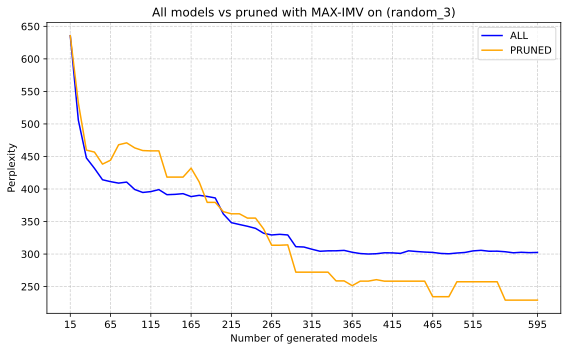

In [13]:
# Test ensemble pruning performance with max imv heuristic
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(3),
    config = RANDOM_CONFIG(3),
    ens_sizes = [i for i in range(15, 601, 10)], # Number of plotted points
    trainset_size=200,
    sample_size=700,
    testset_size=1000,
    n=15,
    skip_train=True,
    skip_diff=False,
    cache_key=RANDOM_3_CACHE_KEY,
    pruning_method = PruningMethod.MaxImv()
)

Skipped generating train and testsets: random_3_200, random_3_1000
Skipped training 595 runs on random_3_200
Skipped diffing
Finished prunning 59 models: 0m 2s
Finished testing 118 runs: 0m 54s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 25: [10 18  8 13 19 21 15 16  0 20  9  1  6 22 24]
Selected from 35: [19 10  9 33  8 24 32 30 15 27 26 11 20 34  4]
Selected from 45: [32 38 27 20 30 16 24 26 10 34 19 15  9  8 18]
Selected from 55: [10  7 19 20 30 29  9 26 49 15 34 32 51 27 18]
Selected from 65: [ 8 26 32 49 20 16 18 51 62 10 19  7 30 27 63]
Selected from 75: [41  9 26 34 20 63 27 10 62 49  3 30 19  8 18]
Selected from 85: [ 7 20 41 19 63 27 44 26 10  4 34 30  3 29 49]
Selected from 95: [23  8 34 87  3 44 10 26 49 20  7 63 19 27 41]
Selected from 105: [19 49 44  7 23 41 29 27  3 20 26 34 10 63 87]
Selected from 115: [44 63 34 87  3 19 29 26 62 27 23 49 10 20 41]
Selected from 125: [ 34  27  63  10  26 123  87   3   7  20  19   2 117  41  49]
Sele

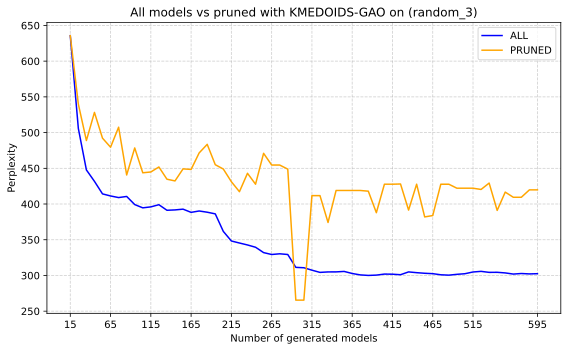

In [14]:
# Test ensemble pruning performance with max imv then kmeans
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(3),
    config = RANDOM_CONFIG(3),
    ens_sizes = [i for i in range(15, 601, 10)], # Number of plotted points
    trainset_size=200,
    sample_size=700,
    n=15,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_3_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao()
)

Skipped generating train and testsets: random_3_200, random_3_1000
Skipped training 595 runs on random_3_200
Skipped diffing


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Finished prunning 59 models: 0m 4s
Finished testing 118 runs: 0m 54s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 25: [3, 13, 18, 19, 20]
Selected from 35: [18, 20, 26, 27]
Selected from 45: [18, 20, 26, 27]
Selected from 55: [10, 18, 20, 26, 27, 49, 51]
Selected from 65: [16, 18, 20, 26, 27, 49, 51]
Selected from 75: [3, 7, 18, 20, 26, 27, 29, 49, 51]
Selected from 85: [3, 18, 20, 26, 27, 29, 41, 62, 63]
Selected from 95: [3, 8, 20, 23, 26, 27, 41, 44, 87]
Selected from 105: [3, 20, 23, 26, 27, 29, 41, 60, 87]
Selected from 115: [3, 23, 26, 27, 29, 41, 44, 62, 87]
Selected from 125: [3, 20, 23, 26, 27, 41, 44, 56, 87, 117]
Selected from 135: [3, 23, 26, 27, 41, 44, 56, 87, 117]
Selected from 145: [3, 7, 20, 23, 26, 27, 44, 49, 87, 117, 136]
Selected from 155: [3, 7, 19, 20, 23, 27, 44, 49, 87, 109, 112, 117, 135, 136]
Selected from 165: [4, 7, 19, 20, 23, 27, 44, 49, 87, 112, 117, 135, 136, 159, 162]
Selected from 175: [3, 4, 7, 20, 23, 27, 44, 49

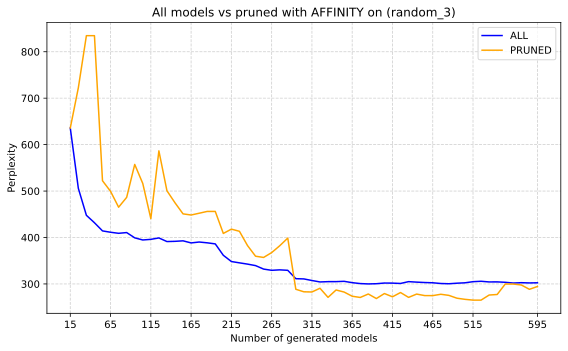

In [15]:
# Test ensemble pruning performance with max imv then kmeans
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(3),
    config = RANDOM_CONFIG(3),
    ens_sizes = [i for i in range(15, 601, 10)], # Number of plotted points
    trainset_size=200,
    sample_size=700,
    n=15,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_3_CACHE_KEY,
    pruning_method=PruningMethod.Affinity()
)

Skipped generating train and testsets: random_3_200, random_3_1000
Skipped training 595 runs on random_3_200
[Cache] Loaded key 501 from .cache\501.pkl
Skipped diffing


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\cluster\_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


Finished prunning 59 models: 0m 4s
Finished testing 118 runs: 1m 43s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 25: [3, 6, 8, 9, 10, 13, 15, 16, 18, 19, 20, 21, 22, 23, 24]
Selected from 35: [9, 10, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 32, 33, 34]
Selected from 45: [9, 10, 18, 19, 20, 23, 24, 25, 26, 27, 29, 30, 32, 34, 38]
Selected from 55: [9, 10, 18, 19, 20, 23, 26, 27, 29, 30, 32, 34, 38, 49, 51]
Selected from 65: [9, 10, 16, 18, 19, 20, 23, 26, 27, 29, 30, 32, 49, 51, 63]
Selected from 75: [3, 7, 9, 10, 18, 19, 20, 23, 26, 27, 29, 30, 32, 49, 51]
Selected from 85: [3, 10, 18, 19, 20, 23, 26, 27, 29, 30, 32, 41, 49, 62, 63]
Selected from 95: [3, 8, 10, 19, 20, 23, 26, 27, 29, 30, 32, 41, 44, 49, 87]
Selected from 105: [3, 9, 10, 20, 23, 26, 27, 29, 30, 32, 41, 49, 60, 87, 97]
Selected from 115: [3, 9, 10, 23, 26, 27, 29, 30, 32, 41, 44, 49, 62, 87, 97]
Selected from 125: [3, 10, 20, 23, 26, 27, 30, 32, 41, 44, 49, 56, 87, 97, 117]
Selected

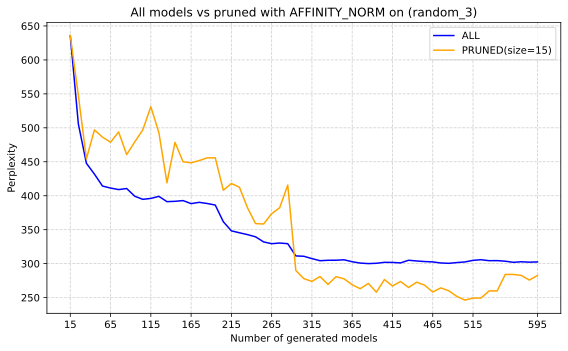

In [5]:
# Test ensemble pruning performance with max imv then kmeans
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(3),
    config = RANDOM_CONFIG(3),
    ens_sizes = [i for i in range(15, 601, 10)], # Number of plotted points
    trainset_size=200,
    sample_size=700,
    n=15,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_3_CACHE_KEY,
    pruning_method=PruningMethod.AffinityNorm()
)

Selections: [9, 10, 21, 22, 23, 30, 32, 38, 39, 45, 49, 51, 61, 70, 72]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


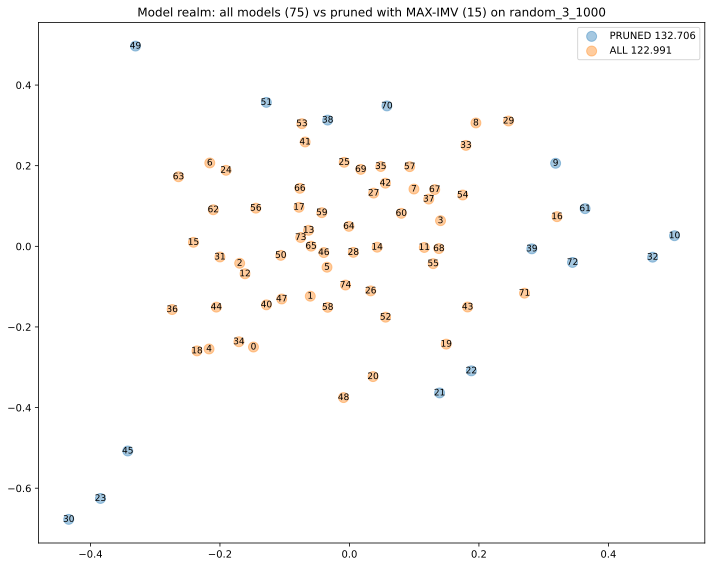

Selections: [32 11 20  8 26  3 43 59 65  9 49 10 13 18 23]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


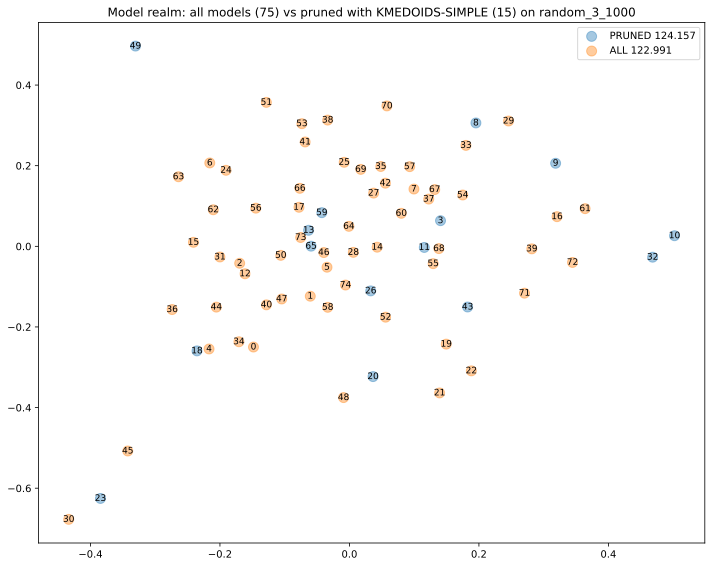

In [ ]:
# Showcase the disparity between MAX-IVM and KMEDOIDS-SIMPLE
eval_pruned_with_distance(
    config = RANDOM_CONFIG(3),
    all_ens_sizes = [i for i in range(15, 201, 10)],
    ens_size_to_plot = 75,
    n=15,
    cache_key=RANDOM_3_CACHE_KEY
)
eval_pruned_with_distance(
    config = RANDOM_CONFIG(3),
    all_ens_sizes = [i for i in range(15, 201, 10)],
    ens_size_to_plot = 75,
    n=15,
    cache_key=RANDOM_3_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsSimple()
)

Selections: [ 65  56 137  13 133  20  48  23  26  18  44  11 131  89  10]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


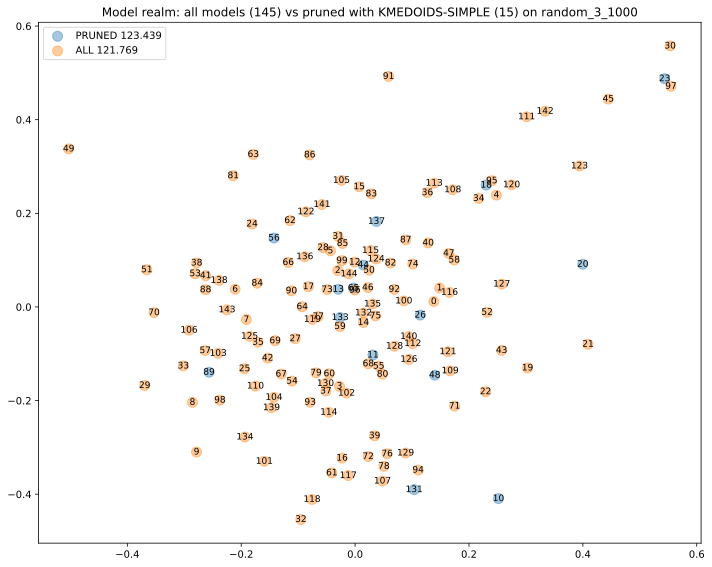

Selections: [ 44 112  16  23  49  13  48  20  18 137  86 133  27 110  26]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


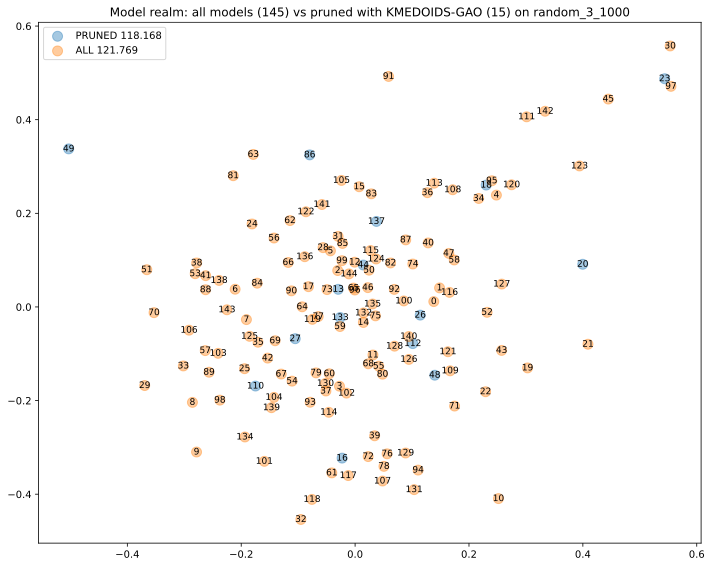

In [25]:
# Showcase the disparity between KMEDOIDS-SIMPLE and KMEDOIDS-GAO
eval_pruned_with_distance(
    config = RANDOM_CONFIG(3),
    all_ens_sizes = [i for i in range(15, 201, 10)],
    ens_size_to_plot = 145,
    n=15,
    cache_key=RANDOM_3_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsSimple()
)
eval_pruned_with_distance(
    config = RANDOM_CONFIG(3),
    all_ens_sizes = [i for i in range(15, 201, 10)],
    ens_size_to_plot = 145,
    n=15,
    cache_key=RANDOM_3_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao()
)

Skipped generating train and testsets: reber_30, reber_1000
Skipped training 600 runs on reber_30
[Cache] Saved data with ID: 507
[Cache] Dumped key 507 to .cache\507.pkl
Finished diffing 60 models: 17m 15s
Finished prunning 60 models: 0m 5s
Finished testing 120 runs: 1m 20s
Selected from 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected from 20: [0, 1, 2, 4, 10, 11, 13, 14, 18, 19]
Selected from 30: [0, 1, 4, 10, 11, 13, 18, 25, 27, 28]
Selected from 40: [1, 4, 10, 11, 13, 18, 25, 27, 32, 38]
Selected from 50: [4, 10, 11, 13, 18, 25, 27, 38, 42, 45]
Selected from 60: [4, 10, 11, 13, 18, 25, 27, 38, 42, 58]
Selected from 70: [4, 10, 11, 25, 27, 58, 60, 63, 64, 67]
Selected from 80: [4, 11, 25, 58, 60, 63, 64, 67, 78, 79]
Selected from 90: [4, 10, 11, 25, 58, 60, 63, 64, 67, 79]
Selected from 100: [4, 10, 11, 25, 58, 60, 63, 64, 67, 79]
Selected from 110: [4, 11, 25, 58, 63, 64, 67, 79, 105, 107]
Selected from 120: [4, 11, 25, 58, 62, 63, 64, 67, 107, 113]
Selected from 130: [4, 11, 25, 58, 6

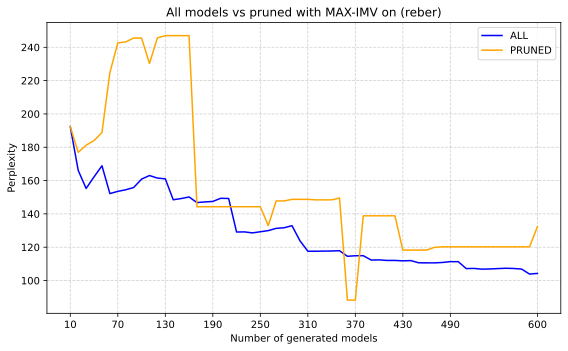

In [16]:
eval_pruned_vs_performance(
    machine = machines.reber(),
    config = REBER_CONFIG,
    ens_sizes = [i for i in range(10, 601, 10)], # Number of plotted points
    trainset_size=30,
    sample_size=300,
    n=10,
    skip_train=True,
    skip_diff=False,
    cache_key=507,
    pruning_method=PruningMethod.MaxImv()
)

Skipped generating train and testsets: reber_30, reber_1000
Skipped training 600 runs on reber_30
Skipped diffing
Finished prunning 60 models: 0m 2s
Finished testing 120 runs: 1m 19s
Selected from 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected from 20: [11 16  2  4  3  0 18 19  5  6]
Selected from 30: [11 16 23 15  7  6  0 18  2 19]
Selected from 40: [ 6 26 11 16 39  2  7  0 23 20]
Selected from 50: [43 11 46 23 24 17 16 26  2  7]
Selected from 60: [ 6 50 20 11 46 53 23 16 24 22]
Selected from 70: [65 53 22 46 30 26 23  6 69 39]
Selected from 80: [22 52 66 65  6 53 26 46 23 69]
Selected from 90: [76 46 22 26 23  6 69 65 39 53]
Selected from 100: [69 23 39 61 26 95 98 53 90 16]
Selected from 110: [98 16 39 95 69 90 26 53 23 61]
Selected from 120: [ 23  61  95  98 119  43  39  53  69  16]
Selected from 130: [ 95  53  98 119  69  16  65  39 123  23]
Selected from 140: [ 53  69 119  39  16  43  23  61  95  98]
Selected from 150: [ 39  98  23  95  61  16  53  69 119 123]
Selected from 160: [ 9

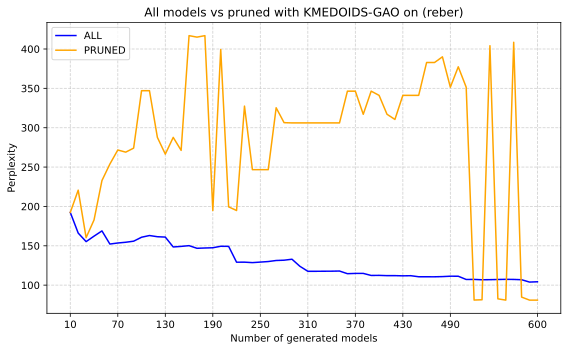

In [17]:
eval_pruned_vs_performance(
    machine = machines.reber(),
    config = REBER_CONFIG,
    ens_sizes = [i for i in range(10, 601, 10)], # Number of plotted points
    trainset_size=30,
    sample_size=300,
    n=10,
    skip_train=True,
    skip_diff=True,
    cache_key=507,
    pruning_method=PruningMethod.KMedoidsGao()
)

Skipped generating train and testsets: reber_30, reber_1000
Skipped training 600 runs on reber_30
Skipped diffing
Finished prunning 60 models: 0m 5s
Finished testing 120 runs: 1m 18s
Selected from 10: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Selected from 20: [0, 2, 5, 6, 11, 16]
Selected from 30: [0, 2, 6, 7, 23, 26]
Selected from 40: [0, 2, 6, 7, 20, 23, 26]
Selected from 50: [0, 2, 7, 11, 23, 26, 43, 46]
Selected from 60: [6, 7, 11, 16, 20, 23, 46, 50, 53]
Selected from 70: [6, 22, 23, 26, 39, 46, 53, 65, 69]
Selected from 80: [6, 22, 23, 26, 39, 46, 53, 65, 69]
Selected from 90: [6, 22, 23, 26, 30, 39, 46, 53, 65, 69, 76]
Selected from 100: [16, 23, 26, 39, 53, 65, 69, 76, 90, 95, 98]
Selected from 110: [16, 22, 23, 26, 30, 39, 46, 53, 65, 69, 76, 90, 98]
Selected from 120: [22, 23, 39, 46, 53, 65, 68, 69, 73, 78, 97, 98, 119]
Selected from 130: [22, 23, 30, 39, 46, 53, 65, 69, 76, 97, 98, 109, 119, 123]
Selected from 140: [23, 30, 39, 43, 53, 65, 69, 73, 76, 97, 98, 102, 119, 130]
Selected 

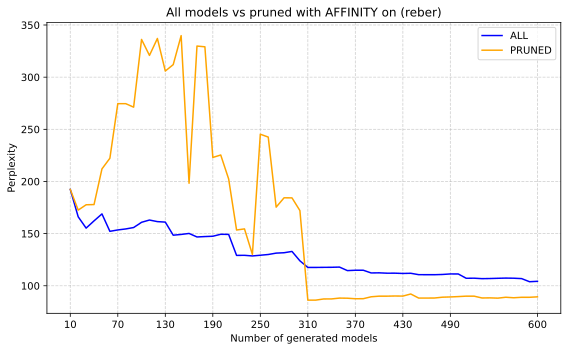

In [18]:
eval_pruned_vs_performance(
    machine = machines.reber(),
    config = REBER_CONFIG,
    ens_sizes = [i for i in range(10, 601, 10)], # Number of plotted points
    trainset_size=30,
    sample_size=300,
    n=10,
    skip_train=True,
    skip_diff=True,
    cache_key=507,
    pruning_method=PruningMethod.Affinity()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
[Cache] Saved data with ID: 503
[Cache] Dumped key 503 to .cache\503.pkl
Finished diffing 33 models: 24m 14s
Finished prunning 33 models: 0m 1s
Finished testing 66 runs: 1m 48s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 26, 27, 29]
Selected from 45: [1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 21, 22, 26, 27, 29, 33, 34, 35, 36, 41, 43, 44]
Selected from 60: [1, 2, 3, 5, 7, 11, 12, 14, 15, 21, 26, 27, 29, 33, 34, 35, 36, 41, 44, 45, 46, 49, 54, 56, 59]
Selected from 75: [1, 2, 5, 7, 11, 12, 14, 15, 21, 26, 33, 35, 36, 41, 44, 45, 46, 49, 54, 56, 59, 62, 67, 68, 72]
Selected from 90: [2, 5, 7, 11, 12, 14, 26, 33, 35, 41, 44, 45, 46, 49, 54, 56, 66, 67, 68, 75, 78, 81, 87, 88, 89]
Selected from 105: [2, 5, 7, 12, 14, 26, 33, 35, 41, 44, 45, 49, 54, 56, 66, 6

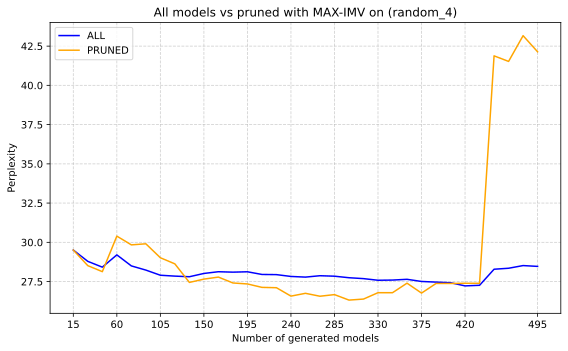

In [19]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=False,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.MaxImv()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
Skipped diffing
Finished prunning 33 models: 0m 1s
Finished testing 66 runs: 1m 49s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 26, 27, 29]
Selected from 45: [1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 19, 21, 22, 26, 27, 29, 30, 34, 35, 36, 41, 44]
Selected from 60: [1, 2, 3, 5, 7, 11, 12, 14, 15, 19, 21, 26, 27, 29, 34, 35, 36, 41, 44, 45, 46, 49, 54, 56, 59]
Selected from 75: [1, 2, 5, 7, 11, 14, 15, 21, 26, 27, 35, 36, 41, 44, 45, 46, 49, 53, 54, 56, 59, 62, 67, 68, 72]
Selected from 90: [2, 5, 7, 11, 12, 14, 26, 27, 35, 36, 41, 44, 45, 46, 49, 54, 56, 66, 67, 68, 78, 81, 87, 88, 89]
Selected from 105: [2, 5, 7, 11, 14, 26, 27, 35, 41, 44, 45, 49, 54, 56, 66, 67, 68, 78, 81, 82, 87, 89, 90, 91, 99]
Selected from 120: [2, 5, 7, 11, 14, 26, 27, 35, 41, 44

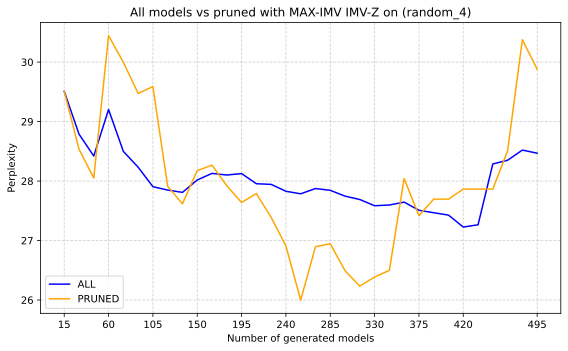

In [20]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.MaxImv().DetectOutliersImvZ()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
Skipped diffing
Finished prunning 33 models: 0m 3s
Finished testing 66 runs: 1m 50s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 26, 27, 29]
Selected from 45: [1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 21, 22, 26, 27, 29, 33, 34, 35, 36, 41, 43, 44]
Selected from 60: [1, 2, 3, 5, 7, 11, 12, 13, 14, 15, 21, 26, 27, 29, 33, 34, 35, 36, 41, 44, 45, 46, 49, 56, 59]
Selected from 75: [1, 2, 5, 7, 11, 12, 14, 15, 27, 33, 35, 36, 41, 44, 45, 46, 49, 54, 56, 59, 62, 66, 67, 68, 72]
Selected from 90: [1, 2, 5, 7, 12, 14, 26, 33, 35, 41, 44, 45, 46, 49, 54, 56, 66, 67, 68, 72, 75, 78, 81, 87, 88]
Selected from 105: [1, 2, 5, 7, 11, 12, 14, 26, 33, 35, 41, 44, 45, 49, 54, 56, 66, 67, 68, 75, 78, 81, 87, 91, 96]
Selected from 120: [2, 5, 7, 12, 14, 26, 33, 35, 41, 44,

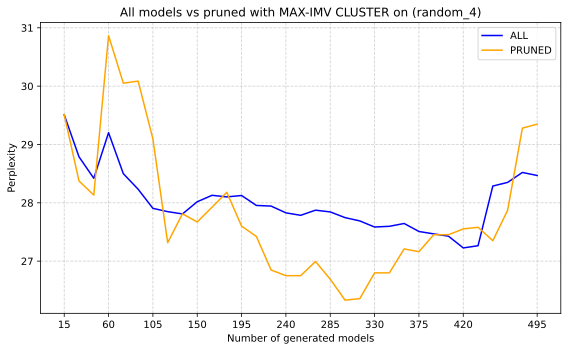

In [21]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.MaxImv().DetectOutliersCluster()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
Skipped diffing
Finished prunning 33 models: 0m 1s
Finished testing 66 runs: 1m 48s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [29 20 27 21 19 16 13 12  5 22 24 26 18  2  1  3  4 14  8  7 15  6 25 17
 11]
Selected from 45: [12 41  5  1 44 14 23 36 21 31 42 35 33  3 26  2 10 18 34 11  7 27 19 30
 20]
Selected from 60: [33 45 11 53 46 24  7  3  5 42 35  2 27 59 49 54 26 44 12 56 41 20 13 51
 58]
Selected from 75: [41  3 67  5  2 54 20 30 12 56 59 69 26 45 66 24 46 31 35 18  7 33 11 42
 53]
Selected from 90: [87 54 35 84 67 30 11 56 20 74 45 59 24 26 42 89  7 33 41  5 27  3  2 69
 31]
Selected from 105: [84 42 89 56 53 59 87 74 33 30 24  7 67 45  5 31 11 20  2 26 35 69 99 12
 41]
Selected from 120: [  2  37   7  74  54  30  42  84  67  89  35  11  45  69  31  26  32  27
  99  75  24 118  18 111  87]
Selected from 135: [ 11  56  45  69  27

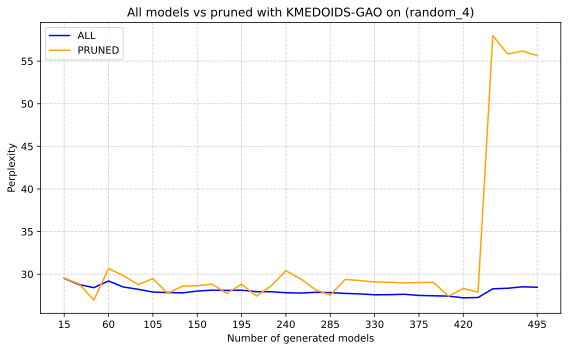

In [22]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
Skipped diffing
Finished prunning 33 models: 0m 2s
Finished testing 66 runs: 1m 48s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [14, 19, 17, 4, 5, 8, 27, 16, 21, 1, 25, 3, 26, 20, 15, 11, 2, 18, 22, 13, 6, 10, 29, 12, 24]
Selected from 45: [14, 30, 33, 1, 35, 20, 27, 17, 12, 2, 8, 7, 24, 42, 21, 36, 11, 26, 5, 3, 41, 19, 44, 34, 18]
Selected from 60: [33, 18, 19, 46, 26, 41, 45, 5, 7, 14, 27, 50, 42, 49, 56, 44, 3, 53, 59, 1, 35, 12, 20, 9, 2]
Selected from 75: [18, 7, 31, 45, 5, 2, 20, 42, 35, 33, 30, 41, 56, 67, 3, 59, 54, 24, 12, 34, 66, 46, 27, 11, 69]
Selected from 90: [67, 41, 35, 42, 2, 84, 69, 45, 24, 20, 56, 87, 54, 12, 7, 26, 31, 74, 53, 3, 5, 59, 11, 75, 30]
Selected from 105: [33, 67, 41, 20, 42, 2, 24, 100, 74, 3, 69, 31, 35, 26, 45, 11, 5, 56, 54, 7, 59, 87, 27, 30, 84]
Selected from 120: [5, 20, 7, 74, 2, 118, 26, 67, 35,

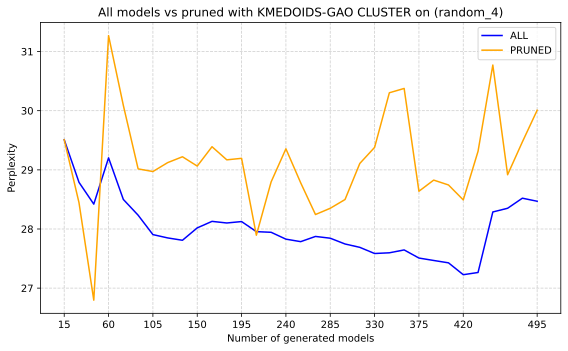

In [23]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao().DetectOutliersCluster()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
Skipped diffing
Finished prunning 33 models: 0m 2s
Finished testing 66 runs: 1m 45s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Selected from 45: [18, 33, 5, 12, 2, 0, 6, 14, 42, 3, 16, 31, 20, 13, 21, 27, 15, 41, 30, 38, 35, 36, 26, 8, 34, 1, 7, 10, 19, 43, 4, 40, 17, 22, 29, 11, 24, 44, 37, 32]
Selected from 60: [8, 46, 16, 11, 3, 12, 53, 27, 10, 1, 41, 13, 21, 58, 34, 57, 19, 5, 59, 47, 6, 51, 30, 44, 26, 55, 42, 36, 45, 52, 7, 14, 56, 33, 18, 35, 9, 20, 2, 49]
Selected from 75: [59, 31, 69, 60, 46, 42, 12, 5, 35, 51, 37, 21, 67, 74, 34, 53, 3, 56, 45, 54, 27, 66, 33, 36, 49, 18, 64, 32, 57, 41, 19, 30, 7, 47, 72, 44, 2, 14, 10, 11]
Selected from 90: [27, 87, 33, 4, 35, 53, 21, 67, 30, 7, 26, 60, 57, 31, 46, 3, 10, 54, 2, 56

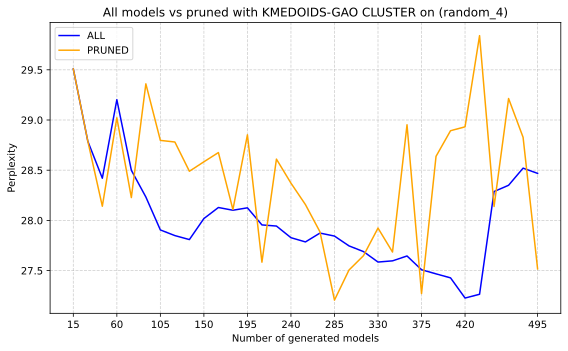

In [28]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=40,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao().DetectOutliersCluster()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
Skipped diffing
Finished prunning 33 models: 0m 1s
Finished testing 66 runs: 1m 53s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [7, 11, 12, 24, 25]
Selected from 45: [11, 12, 13, 17, 20, 24, 42]
Selected from 60: [11, 12, 18, 30, 32, 42, 50, 54]
Selected from 75: [11, 12, 18, 25, 26, 30, 31, 32, 69]
Selected from 90: [11, 24, 27, 32, 33, 37, 42, 69, 74, 84, 89]
Selected from 105: [11, 24, 27, 31, 32, 33, 37, 42, 69, 74, 84, 89, 99]
Selected from 120: [9, 18, 20, 30, 69, 74, 75, 86, 89, 101, 113, 114]
Selected from 135: [9, 18, 30, 32, 69, 75, 86, 89, 108, 113, 114, 116, 120, 133]
Selected from 150: [9, 20, 30, 42, 69, 75, 86, 89, 99, 101, 113, 114, 120, 132, 139]
Selected from 165: [9, 20, 30, 42, 69, 75, 84, 89, 98, 99, 114, 120, 139, 159]
Selected from 180: [9, 20, 30, 33, 34, 42, 69, 89, 98, 99, 120, 139, 140, 159, 169]
Selected from

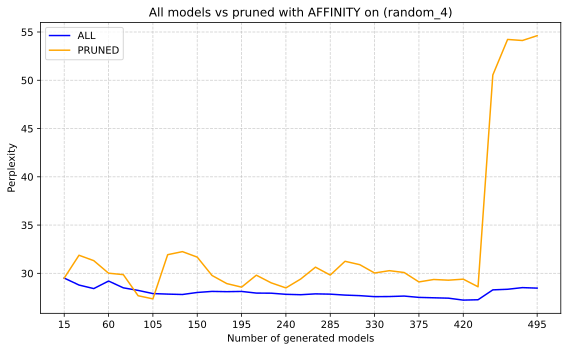

In [24]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.Affinity()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
[Cache] Loaded key 503 from .cache\503.pkl
Skipped diffing
Finished prunning 33 models: 0m 1s
Finished testing 66 runs: 3m 20s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 21, 22, 24, 25, 26, 27, 29]
Selected from 45: [1, 2, 3, 5, 7, 11, 12, 13, 14, 15, 17, 20, 21, 24, 26, 27, 29, 30, 33, 34, 35, 36, 41, 42, 44]
Selected from 60: [1, 2, 5, 7, 11, 12, 14, 18, 21, 26, 30, 32, 33, 35, 36, 41, 42, 44, 45, 46, 49, 50, 54, 56, 59]
Selected from 75: [2, 5, 7, 11, 12, 14, 18, 25, 26, 30, 31, 32, 33, 35, 36, 41, 44, 45, 49, 54, 56, 66, 67, 68, 69]
Selected from 90: [5, 7, 11, 12, 14, 24, 26, 27, 32, 33, 35, 37, 42, 44, 49, 54, 56, 67, 68, 69, 74, 75, 81, 84, 89]
Selected from 105: [5, 7, 11, 12, 14, 24, 26, 27, 31, 32, 33, 35, 37, 42, 49, 54, 56, 67, 68, 69, 74, 75, 84, 89, 99]
Selec

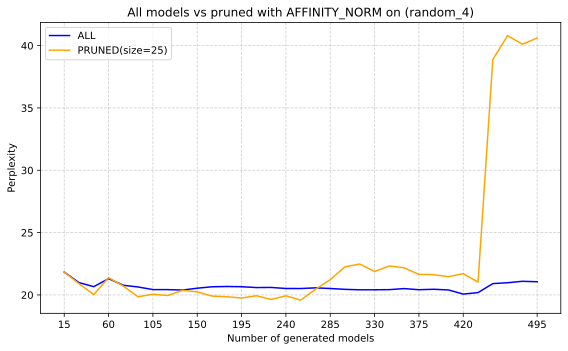

In [4]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.AffinityNorm()
)

Skipped generating train and testsets: random_4_150, random_4_1000
Skipped training 495 runs on random_4_150
Skipped diffing
Finished prunning 33 models: 0m 3s
Finished testing 66 runs: 1m 50s
Selected from 15: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Selected from 30: [11, 12, 24, 25]
Selected from 45: [11, 12, 13, 17, 20, 24, 42]
Selected from 60: [11, 12, 18, 30, 32, 42, 50]
Selected from 75: [11, 18, 25, 27, 30, 31, 32, 33, 69]
Selected from 90: [11, 24, 27, 32, 33, 37, 42, 69, 74, 84]
Selected from 105: [11, 24, 31, 32, 37, 42, 53, 69, 74, 75, 84]
Selected from 120: [9, 18, 20, 30, 69, 74, 75, 86, 101, 113, 114]
Selected from 135: [9, 18, 30, 32, 69, 75, 86, 108, 113, 114, 116, 120, 133]
Selected from 150: [9, 20, 25, 30, 69, 75, 101, 113, 114, 120, 132, 139]
Selected from 165: [9, 20, 30, 34, 69, 75, 84, 86, 98, 120, 139, 140, 159]
Selected from 180: [9, 20, 30, 34, 42, 69, 75, 98, 120, 139, 140, 159, 169]
Selected from 195: [18, 20, 24, 30, 69, 75, 86, 101, 114, 120, 1

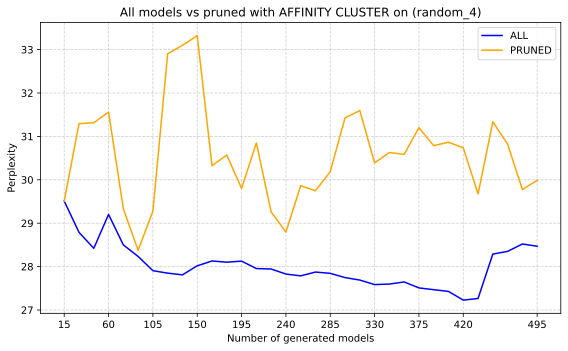

In [26]:
eval_pruned_vs_performance(
    machine = RANDOM_MACHINE(4),
    config = RANDOM_CONFIG(4),
    ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    trainset_size=150,
    sample_size=1000,
    n=25,
    skip_train=True,
    skip_diff=True,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.Affinity().DetectOutliersCluster()
)

Selections: [  0   9  18  46  61  75  84  86  91 120 140 157 199 230 232 235 263 282
 293 302 328 340 364 397 409]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


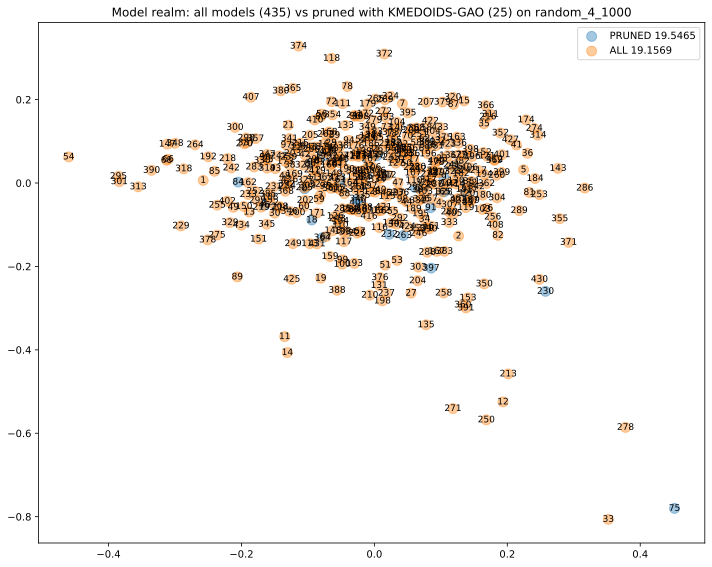

Selections: [  0   9  75  84  91 120 140 141 157 160 208 230 232 235 248 263 293 296
 302 328 340 364 397 409 443]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


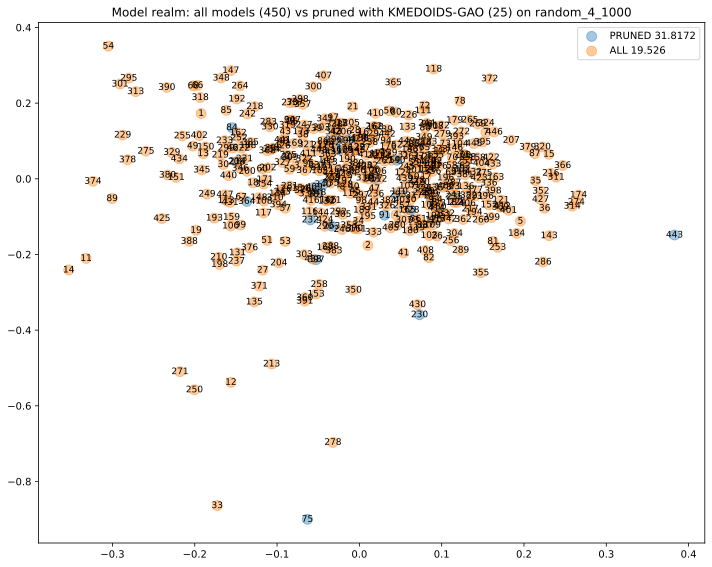

In [17]:
# Showcase the disparity between bad and good clustering?
eval_pruned_with_distance(
    config = RANDOM_CONFIG(4),
    all_ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    ens_size_to_plot = 435,
    n=25,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao()
)
eval_pruned_with_distance(
    config = RANDOM_CONFIG(4),
    all_ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    ens_size_to_plot = 450,
    n=25,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao()
)

In [ ]:
# Investigate model 443
def detect_outliers_z(imv_scores: np.ndarray, z_thresh: float = 2.5) -> list[int]:
    mean = np.mean(imv_scores)
    std = np.std(imv_scores)
    return [i for i, score in enumerate(imv_scores) if (score - mean) / std > z_thresh]

def imv_barchart(
    all_ens_sizes: list[int], # Number of plotted points
    ens_size_to_plot: int,
    cache_key: int,
    z_thresh = 3.0
):
    idx = all_ens_sizes.index(ens_size_to_plot)
    n = ens_size_to_plot

    # Compute the IMV scores
    flat_matrix = CACHE.load(cache_key, from_disk=True)[idx]
    H = var.scores_flat_to_normalized_cross_entropy(flat_matrix, n)
    imv_scores = np.array(var.compute_imv_scores(H, n), dtype=float)

    # Statistical bounds
    mean = float(np.mean(imv_scores))
    std = float(np.std(imv_scores))
    z_cutoff = mean + z_thresh * std

    for i in range(n):
        print(f"Model m={i}: {imv_scores[i]}")

    plt.figure(figsize=(8, 5))

    # Plot the vertical lines
    plt.axvline(mean, color='orange', linestyle='-', linewidth=2.5, label=f"Mean ({mean:.2f})")

    # Std deviation lines
    plt.axvline(mean + std, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label=f"+std ({mean + std:.2f})")

    # Z-threshold cutoff line
    plt.axvline(z_cutoff, color='red', linestyle='-', linewidth=2, label=f"Z-cutoff ({z_cutoff:.2f})")

    # Plot the barplot
    plt.hist(imv_scores, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel("IMV Score")
    plt.ylabel("Number of Models")
    plt.title("Histogram of IMV Scores")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def cluster_sizes(
    all_ens_sizes: list[int], # Number of plotted points
    ens_size_to_plot: int,
    cache_key: int,
    matrix_maker,
    clusterer,
    n = 25
):
    idx = all_ens_sizes.index(ens_size_to_plot)
    m = ens_size_to_plot

    # Compute the IMV scores
    flat_matrix = CACHE.load(cache_key, from_disk=True)[idx]
    M = matrix_maker(flat_matrix, m)
    labels, centers = clusterer(M, m, n)

    # Clustering
    clusters = [[] for _ in centers]
    for i, l in enumerate(labels):
        clusters[l].append(i)

    # Print cluster sizes
    for rep, cluster in sorted(zip(centers, clusters), key=lambda pair: pair[0]):
        print(f"{rep}: {cluster}")



Model m=0: 1159.0909900000001
Model m=1: 1661.1378300000006
Model m=2: 1614.6556500000004
Model m=3: 1252.0998200000004
Model m=4: 1349.2692100000008
Model m=5: 1656.48898
Model m=6: 1105.2318500000001
Model m=7: 1479.8573199999996
Model m=8: 1228.4758700000004
Model m=9: 1199.15282
Model m=10: 1212.5212000000001
Model m=11: 2213.6161500000003
Model m=12: 2785.2082699999996
Model m=13: 1534.8661100000008
Model m=14: 2376.8012
Model m=15: 1574.0895599999994
Model m=16: 1231.6381299999998
Model m=17: 1095.4213099999995
Model m=18: 1335.5294400000005
Model m=19: 1638.9192500000004
Model m=20: 1073.6347899999994
Model m=21: 1348.6700500000006
Model m=22: 1241.9201200000005
Model m=23: 1174.0146200000008
Model m=24: 1138.3918800000006
Model m=25: 1284.68823
Model m=26: 1573.710789999999
Model m=27: 1807.7120100000002
Model m=28: 1180.98117
Model m=29: 1193.1360600000007
Model m=30: 1446.3887200000001
Model m=31: 1124.9827300000002
Model m=32: 1082.0993000000003
Model m=33: 3704.05886
Model 

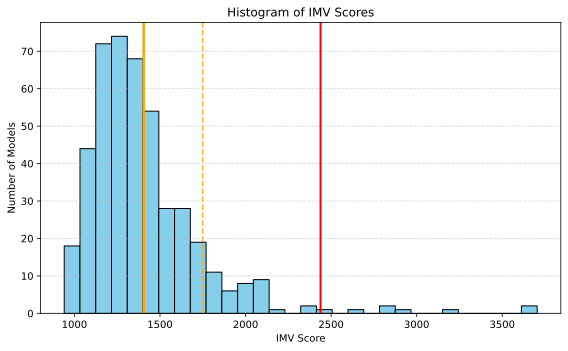

In [10]:
imv_barchart(
    all_ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    ens_size_to_plot=450,
    cache_key=RANDOM_4_CACHE_KEY
)

In [16]:
cluster_sizes(
    all_ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    ens_size_to_plot=450,
    cache_key=RANDOM_4_CACHE_KEY,
    n=25,
    clusterer=var.cluster_ensemble_kmedoids,
    matrix_maker=var.scores_flat_to_distance_matrix_gao
)

0: [0, 89, 95, 164, 173, 225, 229, 233, 252, 299, 309, 319, 322, 338, 385, 413, 441, 447]
9: [4, 9, 26, 36, 79, 102, 110, 119, 178, 220, 304, 317, 333, 401, 408, 414, 436]
75: [33, 75, 278]
84: [1, 13, 46, 54, 59, 66, 84, 85, 150, 188, 192, 214, 255, 295, 301, 313, 318, 329, 390, 392, 402, 426]
91: [44, 64, 91, 101, 109, 195, 226, 353]
120: [93, 120, 136, 280, 307, 311, 352, 355, 417]
140: [16, 31, 55, 65, 72, 73, 76, 77, 78, 80, 94, 96, 104, 114, 122, 124, 127, 133, 139, 140, 146, 155, 170, 172, 175, 176, 177, 179, 183, 185, 186, 187, 201, 221, 228, 234, 244, 245, 261, 265, 267, 269, 272, 273, 276, 279, 282, 285, 294, 306, 308, 324, 344, 349, 356, 393, 395, 404, 437, 445]
141: [6, 21, 32, 56, 111, 141, 145, 168, 205, 238, 247, 262, 330, 341, 357, 410, 448, 449]
157: [8, 20, 35, 37, 40, 41, 45, 47, 52, 61, 106, 107, 108, 112, 115, 117, 118, 132, 144, 149, 152, 154, 157, 166, 174, 193, 197, 202, 236, 240, 259, 268, 281, 284, 290, 297, 331, 334, 354, 384, 418, 422, 444]
160: [3, 48, 63, 

0: [0, 89, 95, 164, 173, 225, 229, 233, 252, 299, 309, 319, 322, 338, 385, 413, 441]
9: [4, 9, 26, 36, 79, 102, 110, 119, 178, 220, 304, 317, 333, 401, 408, 414, 436]
18: [18, 117, 134, 150, 171, 248, 249, 310, 329, 335, 378, 431, 447]
46: [3, 46, 188, 222, 266, 275]
61: [37, 61, 67, 101, 148, 149, 154, 166, 197, 202, 238, 243, 292]
75: [33, 75, 278]
84: [1, 13, 54, 59, 66, 84, 85, 192, 214, 255, 313, 392, 402, 426]
86: [6, 25, 28, 38, 42, 43, 48, 86, 90, 125, 142, 147, 156, 169, 190, 203, 206, 211, 215, 218, 227, 239, 242, 283, 296, 298, 300, 315, 343, 347, 357, 389, 411, 419, 420]
91: [44, 64, 91, 109, 195, 226, 353]
120: [93, 120, 136, 280, 307, 352, 417]
140: [31, 55, 65, 72, 77, 80, 94, 127, 133, 139, 140, 155, 170, 172, 175, 176, 177, 185, 186, 201, 221, 228, 234, 244, 245, 261, 267, 269, 276, 279, 285, 306, 308, 344, 349, 395, 437, 445, 449]
157: [8, 20, 32, 35, 40, 41, 45, 47, 52, 56, 60, 106, 107, 108, 112, 115, 128, 132, 144, 152, 157, 168, 174, 189, 193, 236, 240, 268, 281, 

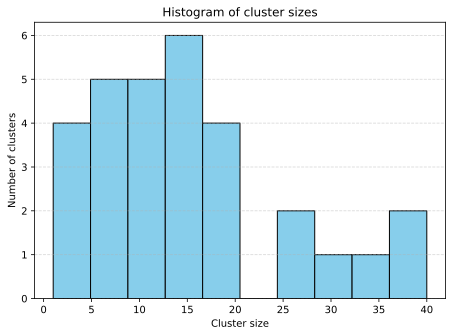

In [12]:
cluster_sizes(
    all_ens_sizes = [i for i in range(15, 501, 15)], # Number of plotted points
    ens_size_to_plot=450,
    cache_key=RANDOM_4_CACHE_KEY,
    n=25,
    clusterer=var.cluster_ensemble_affinity,
    matrix_maker=var.scores_flat_to_similarity_matrix_gao
)

Selections: [ 2  5  7  9 10 11 12 13 14 18 19 20 23 25 27 29 30 33 34 35 37 38 41 42
 44]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


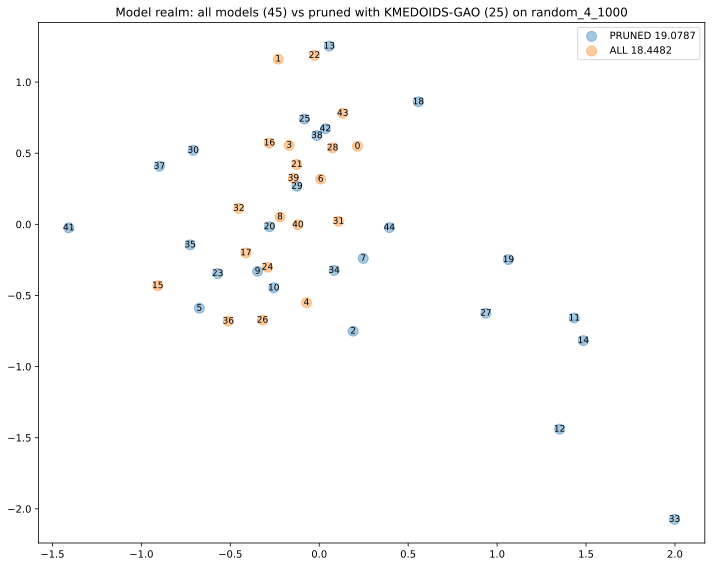

Selections: [ 0  1  2  5  6  7  9 12 14 15 17 19 20 22 27 33 37 41 42 44 45 49 51 55
 57]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


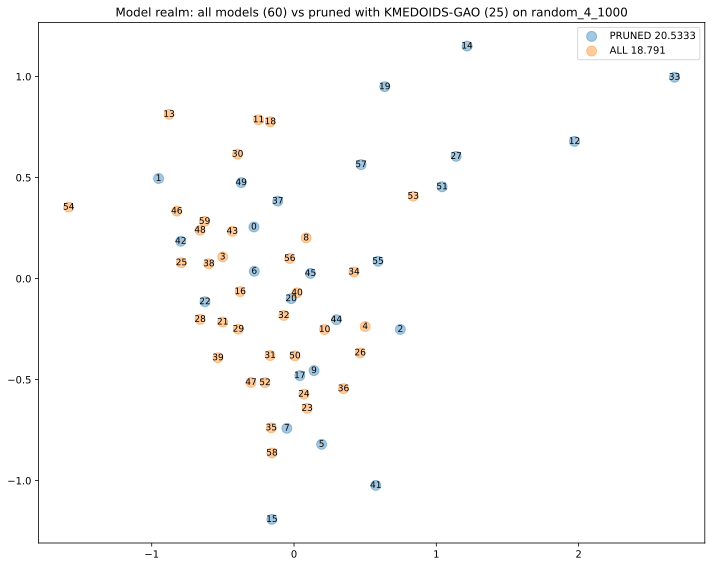

In [ ]:
# Showcase the disparity between bad and good clustering?
eval_pruned_with_distance(
    config = RANDOM_CONFIG(4),
    all_ens_sizes = [i for i in range(15, 301, 15)], # Number of plotted points
    ens_size_to_plot = 45,
    n=25,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao()
)
eval_pruned_with_distance(
    config = RANDOM_CONFIG(4),
    all_ens_sizes = [i for i in range(15, 301, 15)], # Number of plotted points
    ens_size_to_plot = 60,
    n=25,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsGao()
)

Selections: [ 2  3  4  5 10 12 18 26 34 35 36 38 42 44 51 52 53 54 55 60 61 62 65 67
 69]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


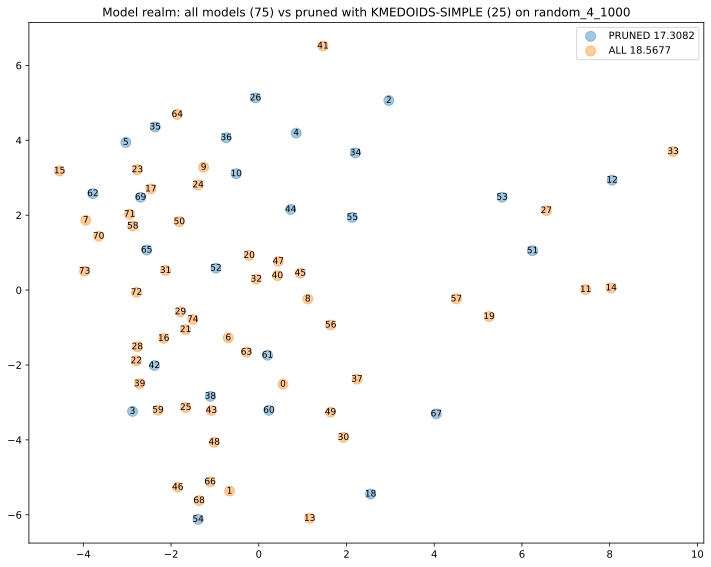

Selections: [ 0  2  4  5  7 10 29 41 44 45 50 51 53 54 55 56 58 61 75 82 83 86 87 88
 89]


c:\Users\blaze\Projects\FlexFringeUtils\.venv\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


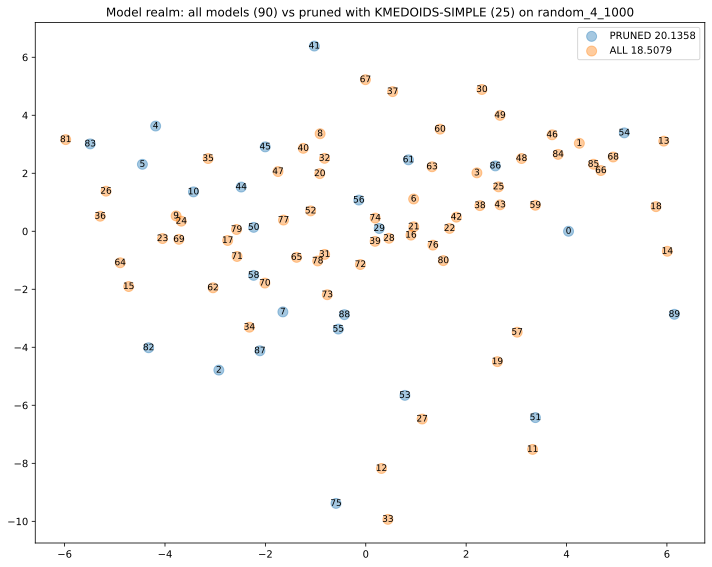

In [29]:
# Showcase the disparity between bad and good clustering?
eval_pruned_with_distance(
    config = RANDOM_CONFIG(4),
    all_ens_sizes = [i for i in range(15, 301, 15)], # Number of plotted points
    ens_size_to_plot = 75,
    n=25,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsSimple(),
    distance_maker=var.scores_flat_to_distance_matrix_simple
)
eval_pruned_with_distance(
    config = RANDOM_CONFIG(4),
    all_ens_sizes = [i for i in range(15, 301, 15)], # Number of plotted points
    ens_size_to_plot = 90,
    n=25,
    cache_key=RANDOM_4_CACHE_KEY,
    pruning_method=PruningMethod.KMedoidsSimple(),
    distance_maker=var.scores_flat_to_distance_matrix_simple
)